In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from auxiliary import plot_cm, plot_nn_metrics, plot_roc, save_metrics, drop_var_nonobj, drop_var_obj, plot_pr_curve

import os
import tempfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#Change path according to directory used
path = r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project\Data\HR_DS.csv'
df = pd.read_csv(path)

In [3]:
# Remove non object variables with no variability
drop_var_nonobj(df)

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [4]:
# Remove object variables with no variability
drop_var_obj(df)

The ['Over18'] column was droped.


In [5]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

patterns = [' ', 'Travel_', '-', '&']

for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


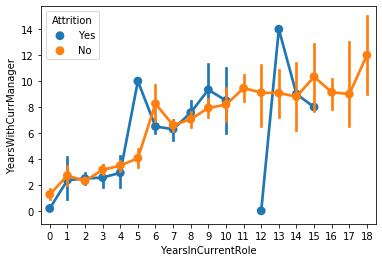

In [6]:
sb.pointplot(df.YearsInCurrentRole, df.YearsWithCurrManager, hue=df.Attrition)
plt.show()

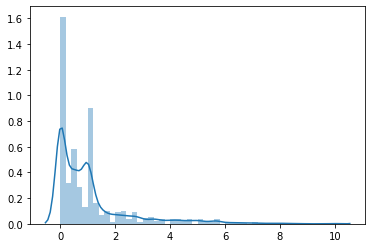

In [7]:
sb.distplot((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))
plt.show()

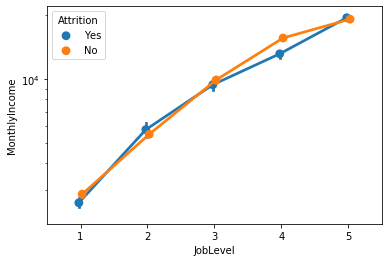

In [8]:
sb.pointplot(df.JobLevel, df.MonthlyIncome, hue=df.Attrition, dodge=True)
plt.yscale('log')
plt.show()

In [9]:
# Score that evaluates the number of years per companies
# The lower the score, the less stable/unexperienced the employee is
# The higher the score, the most stable/experienced the employee it
df['StayScore']=((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))

In [10]:
df.StayScore.describe()

count    1470.000000
mean        1.035314
std         1.430512
min         0.000000
25%         0.000000
50%         0.600000
75%         1.000000
max        10.000000
Name: StayScore, dtype: float64

In [11]:
df.drop(columns=['JobLevel', 'EmployeeNumber', 'TotalWorkingYears', 'NumCompaniesWorked', 'YearsAtCompany'], inplace=True)

In [12]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

Making some dummies

In [13]:
finaldf = pd.get_dummies(df, drop_first=True)

In [14]:
n_features = len(finaldf.columns)
n_features

42

# Models Testing (Train, Test split)
First, the dataset has to be split into 2 sets of data so that the following is available for every model:
* A train dataset (features and labels appart) (90%)
* A test dataset (features and labels appart) (10%)
    * Will be used to test the final models as an out-of-sample dataset.
    
Further on, the models will be evaluated on using Stratified K Fold Testing (5 folds again on the training dataset)

In [15]:
# test 10%; train 90%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=123, stratify=finaldf.Attrition_Yes)

# Initialization of min-max normalizing scaler
minmax = MinMaxScaler()

# Form np arrays of labels and features
train_labels = np.array(train_df.Attrition_Yes)
#bool_train_labels = train_labels != 0
test_labels = np.array(test_df.Attrition_Yes)

# The train and test features will be normalized separatedly in order not to cross-contaminate data
train_features = train_df.drop('Attrition_Yes', axis=1)
test_features = minmax.fit_transform(test_df.drop('Attrition_Yes', axis=1))

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1323,)
Test labels shape: (147,)

Training features shape: (1323, 41)
Test features shape: (147, 41)


A check on the imbalance of the datasets is needed

In [19]:
neg_df, pos_df = np.bincount(finaldf.Attrition_Yes)
total_df = neg_df + pos_df
neg_test, pos_test = np.bincount(test_labels)
total_test = neg_test + pos_test
neg_t, pos_t = np.bincount(train_labels)
total_t = neg_t + pos_t

print('Cases on full dataset:\n\tTotal: {}\n\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_df, pos_df, 100 * pos_df / total_df))
print('\tCases on test dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_test, pos_test, 100 * pos_test / total_test))
print('\tCases on training dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Cases on full dataset:
	Total: 1470
	Employees that Left the company: 237 (16.12% of total)

	Cases on test dataset:
		Total: 147
		Employees that Left the company: 24 (16.33% of total)

	Cases on training dataset:
		Total: 1323
		Employees that Left the company: 213 (16.10% of total)



A determination of the weights of the target label (train dataset) will be important further on the testing of the models

In [51]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg_t)*(total_t)/2
weight_for_1 = (1 / pos_t)*(total_t)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.11


In [20]:
# initialization of the dataframe to store the metrics for each model evaluated on test split
m_summary = pd.DataFrame(columns=['model','tp', 'fp', 'tn', 'fn', 
                                       'acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef', 
                                       'batch_s', 'data', 'series'])

In [21]:
# standart number of folds to be used by StratifiedKfold sampling
n_folds = 10

## 1. XGBoost

In [22]:
from xgboost import XGBClassifier
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

### GridSearch with Stratified K-Fold CV

In [23]:
# fit model on training data
m_XGB = XGBClassifier(n_jobs=-1, learning_rate=0.01, scale_pos_weight=pos_t/neg_t, verbosity=0)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [i for i in range(5,10)],
              'subsample': [0.5, 1],
              'colsample_bytree': [0.5, 1],
              'n_estimators': [100, 1000],
              'seed': [123]}

grid_s = GridSearchCV(m_XGB, parameters, n_jobs=-1,
                      cv=StratifiedKFold(n_splits=n_folds, shuffle=True),
                      scoring='f1',
                      verbose=2, refit=True)

train_feat_norm = minmax.fit_transform(train_features)

grid_s.fit(train_feat_norm, train_labels)
print(grid_s.best_estimator_)
model_XGB = grid_s.best_estimator_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  3.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1918918918918919,
              seed=123, silent=None, subsample=0.5, verbosity=0)


In [25]:
#m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_XGB.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_XGB', ytrain, model_XGB.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_XGB', yval, model_XGB.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...


In [31]:
m_summary.groupby(['model', 'data']).mean()

acc      prec    recall    pr_auc        f1   mc_coef  \
model     data                                                                
model_XGB train  0.991098  1.000000  0.944704  0.999992  0.971555  0.966840   
          val    0.869987  0.769762  0.286364  0.577009  0.412074  0.413766   

                 batch_s  
model     data            
model_XGB train      NaN  
          val        NaN

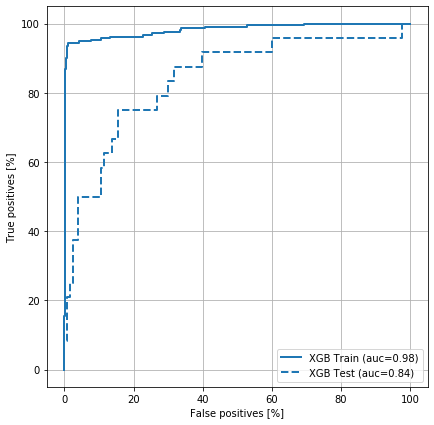

Stayers Detected (True Negatives):  120
Stayers Missed (False Positives):  3
Leavers Missed (False Negatives):  17
Leavers Detected (True Positives):  7


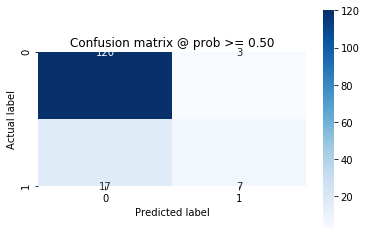

In [48]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_feat_norm)[:, 1], lcolor=colors[0])
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--')
plt.legend(loc='lower right')
plt.show()
plot_cm(test_labels, model_XGB.predict_proba(test_features)[:, 1])

## 2. Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression as LR

### GridSearch with Stratified K-Fold CV

In [52]:
m_log = LR(class_weight=class_weights,
                     random_state=0,
                     multi_class='ovr',
                     n_jobs=-1)

parameters = [{'solver' : ['sag'],
              'C' : [1, 10, 100],
              'max_iter': [10000],
              'penalty' : ('none', 'l2'),
              'warm_start' : (True, False),
              'fit_intercept' : [True, False]},
              {'solver' : ['liblinear', 'saga'], 
              'C' : [1, 10, 100],
              'max_iter': [10000],
              'penalty' : ('l1', 'l2'),
              'warm_start' : (True, False),
              'fit_intercept' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_log, parameters, n_jobs=-1, 
                                              cv=StratifiedKFold(n_splits=n_folds, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)

train_feat_norm = minmax.fit_transform(train_features)

grid_s.fit(train_feat_norm, train_labels)
print(grid_s.best_estimator_)
model_logistic = grid_s.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.3s


LogisticRegression(C=1,
                   class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=-1,
                   penalty='l2', random_state=0, solver='sag', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   24.8s finished


In [54]:
#m_summary = save_metrics(m_summary, 'model_logistic', test_labels, model_logistic.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_logistic.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_logistic', ytrain, model_logistic.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_logistic', yval, model_logistic.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...
...Done


In [63]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model          data                                                     
model_XGB      train  0.99  1.00    0.94    1.00  0.97     0.97      NaN
model_logistic train  0.78  0.40    0.79    0.64  0.53     0.45      NaN
               val    0.75  0.36    0.72    0.58  0.48     0.38      NaN
model_XGB      val    0.87  0.77    0.29    0.58  0.41     0.41      NaN

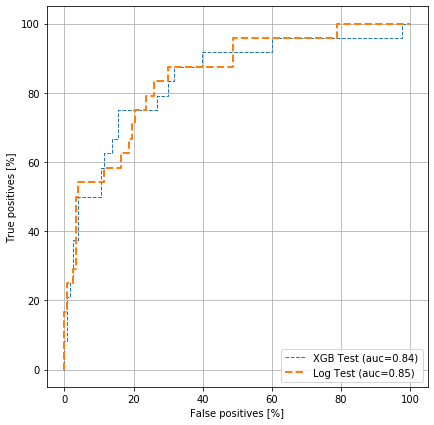

Stayers Detected (True Negatives):  100
Stayers Missed (False Positives):  23
Leavers Missed (False Negatives):  8
Leavers Detected (True Positives):  16


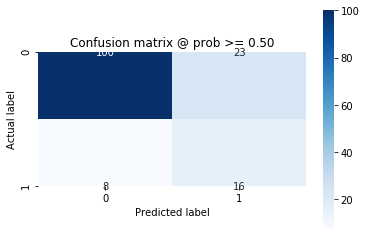

In [57]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--')
plt.legend(loc='lower right')
plt.show()
plot_cm(test_labels, model_logistic.predict_proba(test_features)[:, 1])

## 3. LinearSVC

In [64]:
from sklearn.svm import LinearSVC as LSVC

### GridSearch with Stratified K-Fold CV

In [65]:
m_LinearSVC = LSVC(dual=False,
                   loss = 'squared_hinge',
                   tol=0.0001, 
                   multi_class='ovr', 
                   fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=class_weights, 
                   random_state=0)

parameters = [{'C' : [i for i in range(1,10,2)],
               'penalty' : ['l1', 'l2'],
               'max_iter': [10000, 100000, 1000000]}]

grid_s = sklearn.model_selection.GridSearchCV(m_LinearSVC, parameters, n_jobs=6,
                                              cv=StratifiedKFold(n_splits=n_folds, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)

train_feat_norm = minmax.fit_transform(train_features)

grid_s.fit(train_feat_norm, train_labels)
print(grid_s.best_estimator_)
model_LinearSVC = grid_s.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.7s


LinearSVC(C=1, class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l1',
          random_state=0, tol=0.0001, verbose=0)


[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:   12.4s finished


In [66]:
#m_summary = save_metrics(m_summary, 'model_LinearSVC', test_labels, model_LinearSVC.decision_function(test_features), split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=10, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_LinearSVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_LinearSVC', ytrain, model_LinearSVC.decision_function(xtrain), split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', yval, model_LinearSVC.decision_function(xval), split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...


In [67]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

,,acc,prec,recall,pr_auc,f1,mc_coef,batch_s
model,data,,,,,,,
model_XGB,train,0.99,1.00,0.94,1.00,0.97,0.97,NaN
model_LinearSVC,train,0.88,0.69,0.45,0.64,0.54,0.49,NaN
model_logistic,train,0.78,0.40,0.79,0.64,0.53,0.45,NaN
model_LinearSVC,val,0.87,0.62,0.42,0.59,0.50,0.44,NaN
model_logistic,val,0.75,0.36,0.72,0.58,0.48,0.38,NaN
model_XGB,val,0.87,0.77,0.29,0.58,0.41,0.41,NaN


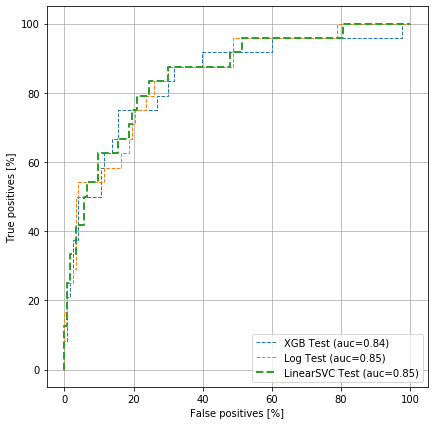

Stayers Detected (True Negatives):  119
Stayers Missed (False Positives):  4
Leavers Missed (False Negatives):  14
Leavers Detected (True Positives):  10


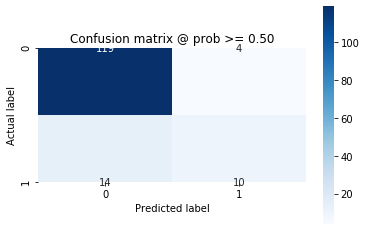

In [69]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_LinearSVC.decision_function(test_features))

## 4. SVC

In [70]:
from sklearn.svm import SVC

### GridSearch with Stratified K-Fold CV

In [71]:
m_SVC = SVC(probability=True, 
            tol=0.001, 
            cache_size=200,
            decision_function_shape='ovr',
            class_weight=class_weights,
            random_state=0,
            max_iter=5000)

parameters = [{'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
               'C' : [i for i in range(1,10,2)],
               'gamma' : [1, 0.1],
               'coef0' : [1, 0.1],
               'shrinking' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_SVC, parameters, n_jobs=-1,
                                              cv=StratifiedKFold(n_splits=n_folds, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)

train_feat_norm = minmax.fit_transform(train_features)

grid_s.fit(train_feat_norm, train_labels)
print(grid_s.best_estimator_)
model_SVC = grid_s.best_estimator_

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200,
    class_weight={0: 0.595945945945946, 1: 3.1056338028169015}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


In [72]:
#m_summary = save_metrics(m_summary, 'model_SVC', test_labels, model_SVC.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_SVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_SVC', ytrain, model_SVC.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_SVC', yval, model_SVC.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...
...Done


In [73]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

,,acc,prec,recall,pr_auc,f1,mc_coef,batch_s
model,data,,,,,,,
model_XGB,train,0.99,1.00,0.94,1.00,0.97,0.97,NaN
model_SVC,train,0.91,0.87,0.54,0.78,0.66,0.64,NaN
model_LinearSVC,train,0.88,0.69,0.45,0.64,0.54,0.49,NaN
model_logistic,train,0.78,0.40,0.79,0.64,0.53,0.45,NaN
model_LinearSVC,val,0.87,0.62,0.42,0.59,0.50,0.44,NaN
model_logistic,val,0.75,0.36,0.72,0.58,0.48,0.38,NaN
model_SVC,val,0.87,0.78,0.32,0.57,0.44,0.44,NaN
model_XGB,val,0.87,0.77,0.29,0.58,0.41,0.41,NaN


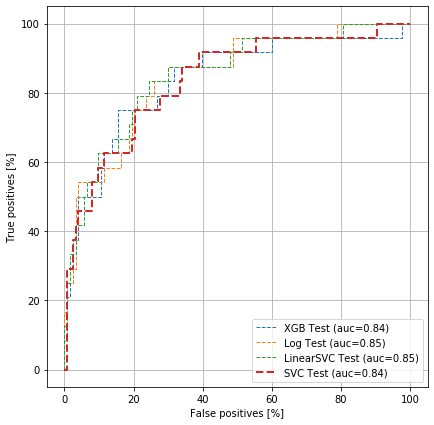

Stayers Detected (True Negatives):  121
Stayers Missed (False Positives):  2
Leavers Missed (False Negatives):  17
Leavers Detected (True Positives):  7


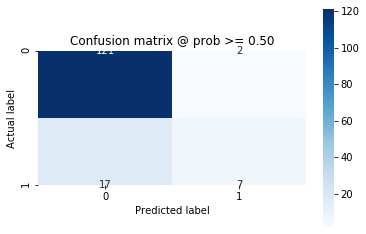

In [74]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_SVC.predict_proba(test_features)[:, 1])

## 5. Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier as RForest

### GridSearch with Stratified K-Fold CV

In [77]:
m_RF = RForest(criterion='gini',
               max_features='auto',
               class_weight=class_weights,
               n_jobs=-1,
               random_state=0)

parameters = [{'n_estimators' : [100, 500, 1000],
               'max_depth' : [i for i in range(3,15,3)],
               'min_samples_split' : [i for i in range (2,4)], 
               'min_samples_leaf' : [i for i in range (2,4)],
               'warm_start' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_RF, parameters, n_jobs=-1,
                                              cv=StratifiedKFold(n_splits=n_folds, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)

train_feat_norm = minmax.fit_transform(train_features)

grid_s.fit(train_feat_norm, train_labels)
print(grid_s.best_estimator_)
model_RandomForest = grid_s.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  3.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.595945945945946,
                                     1: 3.1056338028169015},
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=True)


In [78]:
#m_summary = save_metrics(m_summary, 'model_RandomForest', test_labels, model_RandomForest.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_RandomForest.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_RandomForest', ytrain, model_RandomForest.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_RandomForest', yval, model_RandomForest.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')

Training on fold 1/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 2/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 3/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 4/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 5/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 6/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 7/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 8/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 9/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training on fold 10/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [79]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model              data                                                     
model_XGB          train  0.99  1.00    0.94    1.00  0.97     0.97      NaN
model_RandomForest val    0.94  0.80    0.81    0.88  0.80     0.77      NaN
                   train  0.94  0.79    0.81    0.88  0.80     0.76      NaN
model_SVC          train  0.91  0.87    0.54    0.78  0.66     0.64      NaN
model_LinearSVC    train  0.88  0.69    0.45    0.64  0.54     0.49      NaN
model_logistic     train  0.78  0.40    0.79    0.64  0.53     0.45      NaN
model_LinearSVC    val    0.87  0.62    0.42    0.59  0.50     0.44      NaN
model_logistic     val    0.75  0.36    0.72    0.58  0.48     0.38      NaN
model_SVC          val    0.87  0.78    0.32    0.57  0.44     0.44      NaN
model_XGB          val    0.87  0.77    0.29    0.58  0.41     0.41      NaN

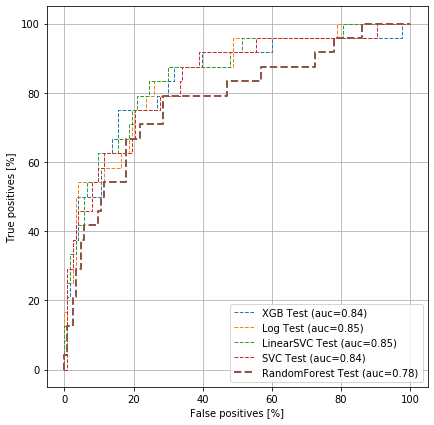

Stayers Detected (True Negatives):  111
Stayers Missed (False Positives):  12
Leavers Missed (False Negatives):  14
Leavers Detected (True Positives):  10


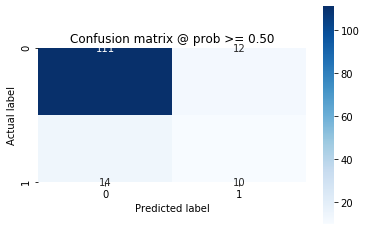

In [81]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[5], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_RandomForest.predict_proba(test_features)[:, 1])

## 6. Keras Tensorflow Classification NN

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [83]:
METRICS = [keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

learn_rate = 0.001

if train_features.shape[-1]%2 == 0:
    n_init_neurons = train_features.shape[-1]
else:
    n_init_neurons = train_features.shape[-1]+1
    
print('The advisable number of neurons in the first layer should be: ', n_init_neurons)

The advisable number of neurons in the first layer should be:  42


In [84]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = Sequential([
        Dense(42, activation=keras.layers.ELU(),
                           input_shape=(train_features.shape[-1],)),
        BatchNormalization(),
        Dense(24, activation=keras.layers.LeakyReLU()), #best 5
        BatchNormalization(),
        Dropout(0.25),
        Dense(1, activation='sigmoid', bias_initializer=output_bias), # sigmoid for regressor with probability output
    ])

    # Designing NN:
    # https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=learn_rate),
        #optimizer=keras.optimizers.Adam(lr=learn_rate),
        #optimizer=keras.optimizers.Nadam(lr=learn_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [85]:
EPOCHS = 100 # max number of epochs (the early stopping callback will cutoff before)
BATCH_SIZE = 32
#best batch size = 64, 70, 32, 128, 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20, #best 20
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=5,
    cooldown=6,
    min_lr=0.00001)

In [86]:
model_keras = make_model()
model_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                1764      
_________________________________________________________________
batch_normalization (BatchNo (None, 42)                168       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1032      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24)                96        
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,085
Trainable params: 2,953
Non-trainable params: 132
____________________________________________________

### Baseline NN

In [87]:
callback = [early_stopping, 
            reduce_lr]

In [93]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

train_feat_norm = minmax.fit_transform(train_features)

model_keras_history = []
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Clear model
    model_keras = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain)
    initial_bias = np.log([pos_nn/neg_nn])
    model_keras = make_model(output_bias = initial_bias)
    results = model_keras.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras.save_weights(initial_weights)

    baseline_history = model_keras.fit(xtrain,
                                       ytrain,
                                       batch_size=BATCH_SIZE,
                                       epochs=EPOCHS,
                                       callbacks = callback,
                                       validation_data=(xval, yval),
                                       verbose=0)
    
    # Debug message
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."
    
    model_keras_history.append(baseline_history)
    m_summary = save_metrics(m_summary, 'NN_base', ytrain, model_keras.predict_proba(xtrain), batch_size=BATCH_SIZE, split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'NN_base', yval, model_keras.predict_proba(xval), batch_size=BATCH_SIZE, split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Training on fold 2/10...
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Training on fold 3/10...
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Training on fold 4/10...
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Training on fold 5/10...
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Training on fold 6/10...
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Training on fold 7/10...
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Training on fold 8/10...
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Training on fold 9/10...
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Training on fold 10

In [94]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model              data                                                     
model_XGB          train  0.99  1.00    0.94    1.00  0.97     0.97      NaN
model_RandomForest val    0.94  0.80    0.81    0.88  0.80     0.77      NaN
                   train  0.94  0.79    0.81    0.88  0.80     0.76      NaN
model_SVC          train  0.91  0.87    0.54    0.78  0.66     0.64      NaN
NN_base            train  0.89  0.87    0.41    0.74  0.55     0.55     32.0
model_LinearSVC    train  0.88  0.69    0.45    0.64  0.54     0.49      NaN
model_logistic     train  0.78  0.40    0.79    0.64  0.53     0.45      NaN
model_LinearSVC    val    0.87  0.62    0.42    0.59  0.50     0.44      NaN
model_logistic     val    0.75  0.36    0.72    0.58  0.48     0.38      NaN
NN_base            val    0.88  0.78    0.32    0.60  0.45     0.44     32.0
model_SVC          val    0.87  0.78    0.32    0.57  0.44     0.44      NaN
model_XGB          val    0.87  0.77    0.29    0.58  0.41     0.41      NaN

In [98]:
train_predictions_baseline = model_keras.predict_proba(train_feat_norm, batch_size=BATCH_SIZE)
test_predictions_baseline = model_keras.predict_proba(test_features, batch_size=BATCH_SIZE)

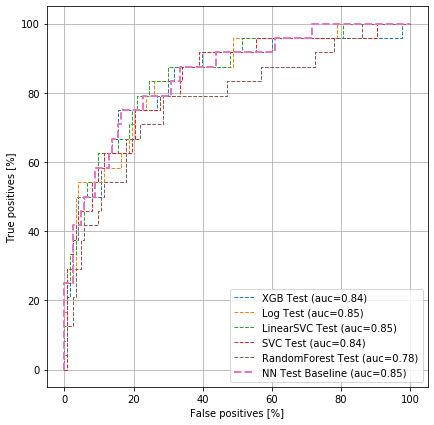

In [99]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[5], lstyle='--', lwidth=1)

plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[6], lstyle='--')
plt.legend(loc='lower right')
plt.show()

### Weighted NN

In [103]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

train_feat_norm = minmax.fit_transform(train_features)

model_keras_w_history = []
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Clear model
    model_keras_w = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain)
    initial_bias = np.log([pos_nn/neg_nn])
    model_keras_w = make_model(output_bias = initial_bias)
    results = model_keras_w.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_w.save_weights(initial_weights)

    baseline_history = model_keras_w.fit(xtrain,
                                       ytrain,
                                       batch_size=BATCH_SIZE,
                                       epochs=EPOCHS,
                                       callbacks = callback,
                                       validation_data=(xval, yval),
                                       # The class weights go here
                                       class_weight=class_weights,
                                       verbose=0)
    
    # Debug message
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."
    
    model_keras_w_history.append(baseline_history)
    m_summary = save_metrics(m_summary, 'NN_weighted', ytrain, model_keras_w.predict_proba(xtrain), batch_size=BATCH_SIZE, split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'NN_weighted', yval, model_keras_w.predict_proba(xval), batch_size=BATCH_SIZE, split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Training on fold 2/10...
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Training on fold 3/10...
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Training on fold 4/10...
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Training on fold 5/10...
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Training on fold 6/10...
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Training on fold 7/10...
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Training on fold 8/10...
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Training on fold 9/10...
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Training on fold 10

In [104]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model              data                                                     
model_XGB          train  0.99  1.00    0.94    1.00  0.97     0.97      NaN
model_RandomForest val    0.94  0.80    0.81    0.88  0.80     0.77      NaN
                   train  0.94  0.79    0.81    0.88  0.80     0.76      NaN
model_SVC          train  0.91  0.87    0.54    0.78  0.66     0.64      NaN
NN_weighted        train  0.84  0.51    0.78    0.71  0.61     0.54     32.0
NN_base            train  0.89  0.87    0.41    0.74  0.55     0.55     32.0
model_LinearSVC    train  0.88  0.69    0.45    0.64  0.54     0.49      NaN
model_logistic     train  0.78  0.40    0.79    0.64  0.53     0.45      NaN
NN_weighted        val    0.80  0.42    0.66    0.58  0.51     0.41     32.0
model_LinearSVC    val    0.87  0.62    0.42    0.59  0.50     0.44      NaN
model_logistic     val    0.75  0.36    0.72    0.58  0.48     0.38      NaN
NN_base            val    0.88  0.78    0.32    0.60  0.45     0.44     32.0
model_SVC          val    0.87  0.78    0.32    0.57  0.44     0.44      NaN
model_XGB          val    0.87  0.77    0.29    0.58  0.41     0.41      NaN

AttributeError: 'list' object has no attribute 'epoch'

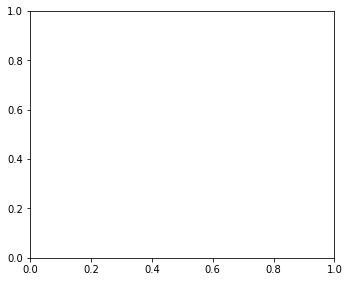

In [105]:
plot_nn_metrics(model_keras_w_history)

In [107]:
train_predictions_weighted = model_keras_w.predict_proba(train_feat_norm, batch_size=BATCH_SIZE)
test_predictions_weighted = model_keras_w.predict_proba(test_features, batch_size=BATCH_SIZE)

In [108]:
m_summary.sort_values(by=['f1', 'recall'], ascending=False).to_csv('preliminary_metrics_models_byf1score.csv')

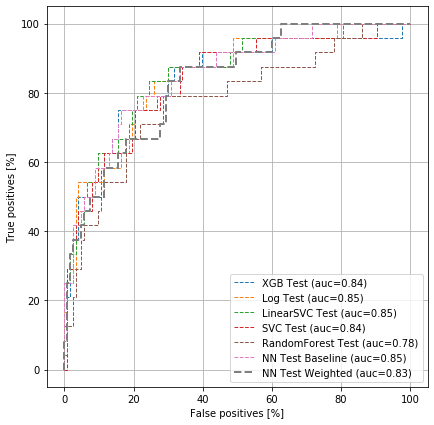

In [109]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[5], lstyle='--', lwidth=1)

plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[6], lstyle='--', lwidth=1)

plot_roc("NN Test Weighted", test_labels, test_predictions_weighted, lcolor=colors[7], lstyle='--')

plt.legend(loc='lower right')
plt.show()

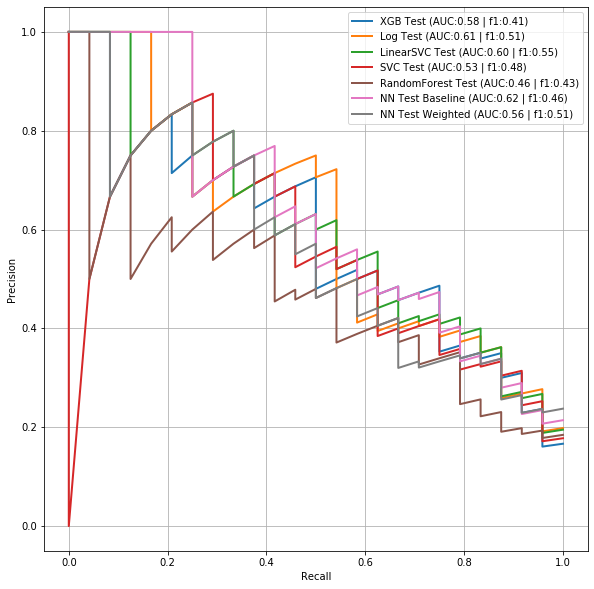

In [111]:
plt.figure(figsize=(10, 10))
plot_pr_curve('XGB Test', test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0])

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1])

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_LinearSVC.predict(test_features), lcolor=colors[2])

plot_pr_curve("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features), lcolor=colors[3])

plot_pr_curve("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], model_RandomForest.predict(test_features), lcolor=colors[5])

plot_pr_curve("NN Test Baseline", test_labels, test_predictions_baseline, model_keras.predict_classes(test_features)[:, 0], lcolor=colors[6])

plot_pr_curve("NN Test Weighted", test_labels, test_predictions_weighted, model_keras_w.predict_classes(test_features)[:, 0], lcolor=colors[7])

plt.legend(loc='upper right')
plt.show()

# Further model exploration

In [121]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  \
model              data  series                                         
model_XGB          train imbalanced  0.99  1.00    0.94    1.00  0.97   
model_RandomForest val   imbalanced  0.94  0.80    0.81    0.88  0.80   
                   train imbalanced  0.94  0.79    0.81    0.88  0.80   
model_SVC          train imbalanced  0.91  0.87    0.54    0.78  0.66   
NN_base            train imbalanced  0.89  0.87    0.41    0.74  0.55   
NN_weighted        train imbalanced  0.84  0.51    0.78    0.71  0.61   
model_LinearSVC    train imbalanced  0.88  0.69    0.45    0.64  0.54   
model_logistic     train imbalanced  0.78  0.40    0.79    0.64  0.53   
NN_base            val   imbalanced  0.88  0.78    0.32    0.60  0.45   
model_SVC          val   imbalanced  0.87  0.78    0.32    0.57  0.44   
model_LinearSVC    val   imbalanced  0.87  0.62    0.42    0.59  0.50   
model_XGB          val   imbalanced  0.87  0.77    0.29    0.58  0.41   
NN_weighted        val   imbalanced  0.80  0.42    0.66    0.58  0.51   
model_logistic     val   imbalanced  0.75  0.36    0.72    0.58  0.48   

                                     mc_coef  batch_s  
model              data  series                        
model_XGB          train imbalanced     0.97      NaN  
model_RandomForest val   imbalanced     0.77      NaN  
                   train imbalanced     0.76      NaN  
model_SVC          train imbalanced     0.64      NaN  
NN_base            train imbalanced     0.55     32.0  
NN_weighted        train imbalanced     0.54     32.0  
model_LinearSVC    train imbalanced     0.49      NaN  
model_logistic     train imbalanced     0.45      NaN  
NN_base            val   imbalanced     0.44     32.0  
model_SVC          val   imbalanced     0.44      NaN  
model_LinearSVC    val   imbalanced     0.44      NaN  
model_XGB          val   imbalanced     0.41      NaN  
NN_weighted        val   imbalanced     0.41     32.0  
model_logistic     val   imbalanced     0.38      NaN

## A. UpSampling with SMOTE

In [113]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [114]:
train_features_res, train_labels_res = SMOTE().fit_resample(train_features, train_labels)

In [25]:
#m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_XGB.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_XGB', ytrain, model_XGB.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_XGB', yval, model_XGB.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...


## C. Recursive Feature Selection with Stratified Kfold CV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklea

Optimal number of features : 5


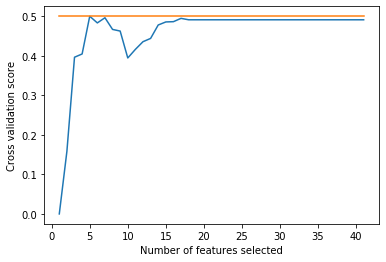

In [72]:
from sklearn.feature_selection import RFECV

# Logistic Model
rfecv = RFECV(estimator=model_logistic, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=0),
              scoring='f1')
#rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)
rfecv.fit(test_features, test_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), [max(rfecv.grid_scores_) for i in range(1, len(rfecv.grid_scores_) + 1)])
plt.show()

In [73]:
l = []
for (i, feat), rank in zip(enumerate(test_df.columns), rfecv.ranking_):
    if rank == 1:
        l.append((feat, i))
print('Best ranking features:\n',l)

Best ranking features:
 [('DistanceFromHome', 2), ('MonthlyIncome', 8), ('WorkLifeBalance', 15), ('JobRole_Manager', 33), ('MaritalStatus_Single', 40)]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Optimal number of features : 9


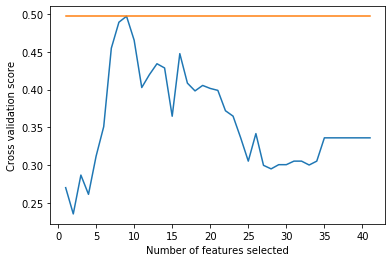

In [74]:
# LinearSVC Model
rfecv = RFECV(estimator=model_LinearSVC, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=0),
              scoring='f1')
#rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)
rfecv.fit(test_features, test_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), [max(rfecv.grid_scores_) for i in range(1, len(rfecv.grid_scores_) + 1)])
plt.show()

In [75]:
l = []
for (i, feat), rank in zip(enumerate(test_df.columns), rfecv.ranking_):
    if rank == 1:
        l.append((feat, i))
print('Best ranking features:\n',l)

Best ranking features:
 [('DistanceFromHome', 2), ('PercentSalaryHike', 10), ('WorkLifeBalance', 15), ('StayScore', 19), ('Attrition_Yes', 20), ('Gender_Male', 30), ('JobRole_Manager', 33), ('JobRole_ManufacturingDirector', 34), ('MaritalStatus_Single', 40)]


## D. Feature importance

In [76]:
m_summary[m_summary.recall > 0.3].sort_values(by=['f1','recall'], ascending=False).head(4)

,model,tp,fp,tn,fn,acc,prec,recall,pr_auc,f1,mc_coef,batch_s
2,model_LinearSVC,11,4,119,13,0.884354,0.733333,0.458333,0.608130,0.564103,0.519930,NaN
1,model_logistic,17,24,99,7,0.789116,0.414634,0.708333,0.577695,0.523077,0.422970,NaN
3,model_SVC,8,2,121,16,0.877551,0.800000,0.333333,0.593737,0.470588,0.465433,NaN
7,NN_weighted,11,12,111,13,0.829932,0.478261,0.458333,0.504426,0.468085,0.367043,256.0


### D.1 Logistic Model

In [77]:
from scipy import stats
params = np.append(model_logistic.intercept_,model_logistic.coef_)
predictions = model_logistic.predict(test_features)

newX = pd.DataFrame({"Constant":np.ones(len(test_features))}).join(pd.DataFrame(test_features))
MSE = (sum((test_labels-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["features"],myDF3["coef"],myDF3["se"],myDF3["t_values"],myDF3["p_value"] = [['intercept']+test_df.columns.to_list(), params,sd_b,ts_b,p_values]
myDF3[myDF3['p_value'] < 0.05].sort_values(by=['coef'], ascending=False)

ValueError: Length of values does not match length of index

Least important features:

In [ ]:
myDF3[myDF3['p_value'] > 0.05].sort_values(by=['coef'], ascending=False)

### D.2 XGBoost

In [ ]:
import xgboost

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,10))
#model_XGB.get_booster().feature_names = train_df.columns
xgboost.plot_importance(model_XGB, height=0.5, ax=ax)
plt.show()

### D.3 LinearSVC

In [ ]:
lsvc = pd.DataFrame({'features':test_df.columns, 'coefs':model_LinearSVC.coef_.ravel()}).sort_values(by='coefs')
lsvc_pos_class = lsvc[lsvc.coefs > 0].sort_values(by='coefs', ascending=False)
lsvc_neg_class = lsvc[lsvc.coefs < 0].sort_values(by='coefs', ascending=True)

In [ ]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_pos_class.coefs, lsvc_pos_class.features, palette="RdYlBu")
plt.title('Coefs favoring attrition')
plt.show()

In [ ]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_neg_class.coefs*-1, lsvc_neg_class.features, palette="RdYlBu")
plt.title('coefs protecting against attrition')
plt.show()

In [ ]:
from mlxtend.evaluate import feature_importance_permutation

In [ ]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_LinearSVC.predict, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=100,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("LinearSVC feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
#plt.barh(test_df.columns[indices], imp_vals[indices], xerr=std[indices])
#plt.yticks(range(X.shape[1]), test_df.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

### D.4 Weighted NN

In [ ]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=weighted_model.predict_classes, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=50,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("Weighted NN feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
plt.ylim([-1, X.shape[1]])
plt.show()